In [17]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import uproot
import os
import glob
from itertools import chain
from copy import deepcopy
import plotly.graph_objs as go
import plotly.express as px
from tqdm import tqdm
from particle import Particle, InvalidParticle, ParticleNotFound
from dataclasses import dataclass, field
from typing import Tuple

In [28]:
@dataclass()
class Hit:
    x: float = field(default=0)
    y: float = field(default=0)
    z: float = field(default=0)
    charge: float = field(default=0)
    energy: float = field(default=0)
    pdgc: int = field(default=0)
    layer: int = field(default=0)
    
    def __hash__(self):
        return hash((self.x, self.y, self.z))
    
    def __eq__(self, other):
        if isinstance(other, Hit):
            return (self.x == other.x and self.y == other.y and self.z == other.z)
        return False

In [19]:
def rotate_vec2D(vec, theta, origin=(0,0)):
 
    translated_vec = vec.translate(-origin)
    
    # Define the rotation matrix
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    # Apply the rotation matrix to the coordinates
    rotated_vec = np.dot(translated_vec, rotation_matrix)
    return rotated_vec.translate(origin, modify=True)

def rotate_point(px, py, cx, cy, angle):
    s = np.sin(angle)
    c = np.cos(angle)
    px -= cx
    py -= cy
    xnew = px * c - py * s
    ynew = px * s + py * c
    px = xnew + cx
    py = ynew + cy
    return px, py


def point_in_rectangle(px, py, rect):
    rx_min, rx_max = min(rect[:, 0]), max(rect[:, 0])
    ry_min, ry_max = min(rect[:, 1]), max(rect[:, 1])
    return rx_min < px < rx_max and ry_min < py < ry_max



def check_overlap(x_length, y_length, angle1, angle2, point, center):
    # Define the vertices of the base rectangle (centered at origin, for example)
    
    length = min((x_length, y_length))
    width = max((x_length, y_length))
    
    rect1 = np.array([[-length, -width], [length, -width], [length, width], [-length, width]])
    
    # Apply rotation to the vertices of the second rectangle
    rect2 = np.array([rotate_point(x, y, *(0,0), angle2) for x, y in rect1])
    rect3 = np.array([rotate_point(x, y, *(0,0), angle1) for x, y in rect1])

    centred_px = point[0] - center[0]
    centred_py = point[1] - center[1]
    
    rot_point = rotate_point(centred_px, centred_py, *(0,0), angle2)
    
    # Check if the point is within both rectangles
    inside_rect2 = point_in_rectangle(centred_px, centred_py, rect3)
    inside_rect3 = point_in_rectangle(rot_point[0], rot_point[1], rect1)

    # Determine if the point is in the overlapping area
    in_overlap = inside_rect2 and inside_rect3
    
    return in_overlap

class vector2D:
    
    def __init__(self, direction, anchor):
        self.direction = direction
        self.anchor = anchor
        
    def rotate(self, theta, origin=None, modify=False):
        
        if origin is None:
            origin = np.array([0, 0])   
        
        translated_vec = self.translate(-origin)
        
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
            ])
        
        direction = np.dot(translated_vec.direction, rotation_matrix)
        rotated_anchor = np.dot(translated_vec.anchor, rotation_matrix)
    
        anchor = rotated_anchor + origin
        
        if not modify:
            return vector2D(direction, anchor)
        
        self.direction = direction
        self.anchor = anchor
        return self
    
    def __str__(self):
        return f"vector2D: direction={self.direction} anchor={self.anchor}"
    
    def compute_intercept(self, other):
        direction_matrix = np.array([[self.direction[0], other.direction[0]], [self.direction[1], other.direction[1]]])
        b = other.anchor - self.anchor
        
        if np.linalg.det(direction_matrix) == 0:
            print("Error: Lines are parallel")
            raise ValueError
        
        t, u = np.linalg.solve(direction_matrix, b)
        
        return self.anchor + t * self.direction
    
    def get_end(self, length):
        
        return self.anchor + (self.direction * length)
    
    def translate(self, amount, modify=False):
        
        anchor = self.anchor + amount
        
        if not modify:
            return vector2D(self.direction, anchor)

        self.anchor = anchor
        return self
    

    def distance_to_point(self, point, length):

        # Extract coordinates
        x0, y0 = point
        x1, y1 = self.anchor
        x2, y2 = self.get_end(length)
        
        # Calculate the components of the distance formula
        numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        
        # Calculate the distance
        distance = numerator / denominator
        return distance




In [20]:
class vector2D:
    
    def __init__(self, direction, anchor):
        self.direction = direction
        self.anchor = anchor
        
    def rotate(self, theta, origin=None, modify=False):
        
        if origin is None:
            origin = np.array([0, 0])   
        
        translated_vec = self.translate(-origin)
        
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
            ])
        
        direction = np.dot(translated_vec.direction, rotation_matrix)
        rotated_anchor = np.dot(translated_vec.anchor, rotation_matrix)
    
        anchor = rotated_anchor + origin
        
        if not modify:
            return vector2D(direction, anchor)
        
        self.direction = direction
        self.anchor = anchor
        return self
    
    def __str__(self):
        return f"vector2D: direction={self.direction} anchor={self.anchor}"
    
    def compute_intercept(self, other):
        direction_matrix = np.array([[self.direction[0], other.direction[0]], [self.direction[1], other.direction[1]]])
        b = other.anchor - self.anchor
        
        if np.linalg.det(direction_matrix) == 0:
            print("Error: Lines are parallel")
            raise ValueError
        
        t, u = np.linalg.solve(direction_matrix, b)
        
        return self.anchor + t * self.direction
    
    def get_end(self, length):
        
        return self.anchor + (self.direction * length)
    
    def translate(self, amount, modify=False):
        
        anchor = self.anchor + amount
        
        if not modify:
            return vector2D(self.direction, anchor)

        self.anchor = anchor
        return self
    

    def distance_to_point(self, point, length):

        # Extract coordinates
        x0, y0 = point
        x1, y1 = self.anchor
        x2, y2 = self.get_end(length)
        
        # Calculate the components of the distance formula
        numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        
        # Calculate the distance
        distance = numerator / denominator
        return distance




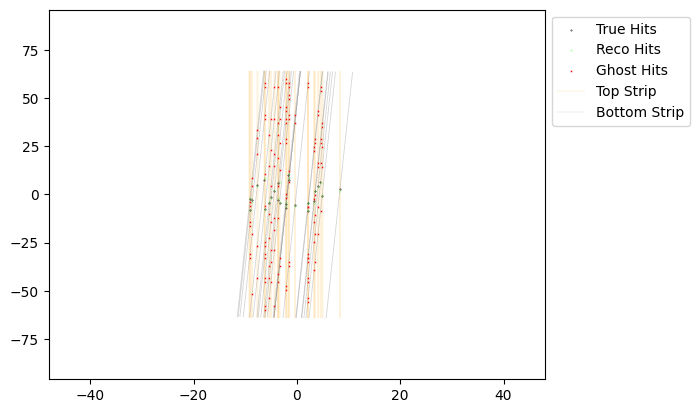

In [40]:
@dataclass()
class Hit:
    x: float = field(default=0)
    y: float = field(default=0)
    z: float = field(default=0)
    charge: float = field(default=0)
    energy: float = field(default=0)
    pdgc: int = field(default=0)
    layer: int = field(default=0)
    
    def __hash__(self):
        return hash((self.x, self.y, self.z))
    
    def __eq__(self, other):
        if isinstance(other, Hit):
            return (self.x == other.x and self.y == other.y and self.z == other.z)
        return False

class SCTModule():
    
    def __init__(self, xpos=0, ypos=0, zpos=0, layer=0, width=63.56, length=128.05, nstrips=768, stereo_angle=0.04, rotation=0, flip=False, name=""):
        
        self.xpos = xpos
        self.ypos = ypos
        self.zpos = zpos
        self.layer = layer
        self.width = width
        self.length = length
        self.nstrips = nstrips
        self.stereo_angle = stereo_angle
        if flip:
            self.stereo_angle *= -1
        self.rotation = rotation
        
        self.name = name
        
        # Init strip vectors 
        #* Baseline module: top strips are oriented vertically in the y-direction
        #*                  bottom strips are rotated by stereo angle
        vertical_unit_vec = vector2D(np.array([0, 1]), np.array(([self.xpos, self.ypos])))
        
        self.top_strips = []
        self.bottom_strips = []
        
        for dx in np.linspace(-self.width/2, width/2, self.nstrips+1):
            self.top_strips.append(vertical_unit_vec.translate([dx, -self.length/2]).rotate(self.rotation, origin=np.array([self.xpos, self.ypos])))
            self.bottom_strips.append(vertical_unit_vec.translate([dx, -self.length/2]).rotate(self.rotation+self.stereo_angle, origin=np.array([self.xpos, self.ypos])))
        
    
    def get_hit_strips(self, hits):
        
        top_hit_strip_pairs = []
        bottom_hit_strip_pairs = []
        
        for hit in hits:
            distances_top = []
            distances_bottom = []

            if not check_overlap(self.width/2, self.length/2, self.rotation, self.rotation+self.stereo_angle, (hit.x, hit.y), (self.xpos, self.ypos)):
                continue
            
            for strip in self.top_strips:
                strip_to_hit_distance = strip.distance_to_point([hit.x, hit.y], self.length)
                distances_top.append(strip_to_hit_distance)
        
            sorted_indices = np.argsort(distances_top)
            closest_lines = sorted_indices[:2]
            closest_lines = sorted(closest_lines)
            
            top_hit_strip_pairs += [[self.top_strips[l] for l in closest_lines]]
            
            for strip in self.bottom_strips:
                strip_to_hit_distance = strip.distance_to_point([hit.x, hit.y], self.length)
                distances_bottom.append(strip_to_hit_distance)
        
            sorted_indices = np.argsort(distances_bottom)
            closest_lines = sorted_indices[:2]
            closest_lines = sorted(closest_lines)
            
            bottom_hit_strip_pairs += [[self.bottom_strips[l] for l in closest_lines]]
            
        return top_hit_strip_pairs, bottom_hit_strip_pairs
    
    
    def get_space_points(self, hits):
        
        top_hit_strip_pairs, bottom_hit_strip_pairs = self.get_hit_strips(hits)
        
        x_intersection_points = []
        y_intersection_points = []
        
        space_points = set()
    
        for top_strip1, top_strip2 in top_hit_strip_pairs:
            for bottom_strip1, bottom_strip2 in bottom_hit_strip_pairs:
                
                is_valid = True                
                
                intercept_11 = top_strip1.compute_intercept(bottom_strip1)
                intercept_12 = top_strip1.compute_intercept(bottom_strip2)
                intercept_21 = top_strip2.compute_intercept(bottom_strip1)
                intercept_22 = top_strip2.compute_intercept(bottom_strip2)
    
                if check_overlap(self.width/2, self.length/2, self.rotation, self.rotation+self.stereo_angle, intercept_11, (self.xpos, self.ypos)):
                    x_intersection_points.append(intercept_11[0])
                    y_intersection_points.append(intercept_11[1])
                else:
                    is_valid = False
                
                if check_overlap(self.width/2, self.length/2, self.rotation, self.rotation+self.stereo_angle, intercept_12, (self.xpos, self.ypos)):
                    x_intersection_points.append(intercept_12[0])
                    y_intersection_points.append(intercept_12[1])
                else:
                    is_valid = False
                
                if check_overlap(self.width/2, self.length/2, self.rotation, self.rotation+self.stereo_angle, intercept_21, (self.xpos, self.ypos)):
                    x_intersection_points.append(intercept_21[0])
                    y_intersection_points.append(intercept_21[1])
                else:
                    is_valid = False
                
                if check_overlap(self.width/2, self.length/2, self.rotation, self.rotation+self.stereo_angle, intercept_22, (self.xpos, self.ypos)):
                    x_intersection_points.append(intercept_22[0])
                    y_intersection_points.append(intercept_22[1])
                else:
                    is_valid = False
                
                if is_valid:
                    sp = Hit()
                    sp.x = (intercept_11[0] + intercept_12[0] + intercept_21[0] + intercept_22[0]) / 4
                    sp.y = (intercept_11[1] + intercept_12[1] + intercept_21[1] + intercept_22[1]) / 4
                    sp.z = self.zpos
                    sp.layer = self.layer
                    sp.charge = 1
                    sp.pdgc = 0
                    sp.energy = 0
                    
                    # if sp_x not in space_points_x and sp_y not in space_points_y: 
                    space_points.add(sp)

        return list(space_points), (top_hit_strip_pairs, bottom_hit_strip_pairs), (x_intersection_points, y_intersection_points)

    def sort_hits_from_ghosts(self, hits, space_points):
        
        reco_hits = set()
        
        for i, hit in enumerate(hits):
            smallest_distance = 10e10
            
            if not check_overlap(self.width/2, self.length/2, self.rotation, self.rotation+self.stereo_angle, (hit.x, hit.y), (self.xpos, self.ypos)):
                continue
            
            best_idx = None
            for j, sp in enumerate(space_points):
                
                distance = np.sqrt((hit.x - sp.x)**2 + (hit.y - sp.y)**2)
                
                if distance < smallest_distance:
                    smallest_distance = distance
                    best_idx = j
            
            reco_hit = space_points[best_idx]
            reco_hit.pdgc = hit.pdgc
            reco_hit.charge = hit.charge
            reco_hit.energy = hit.energy
            reco_hit.layer = hit.layer
            reco_hit.z = hit.z
            
            reco_hits.add(reco_hit)
            
        ghost_hits = set(space_points).difference(reco_hits)

        if len(reco_hits) != 0:
            reco = np.array(list(reco_hits))
        else:
            reco = np.array([])
        
        if len(ghost_hits) != 0:            
            ghosts = np.array(list(ghost_hits))
            
        else:
            ghosts
        
        return reco, ghosts
    

    def get_reco_and_ghost_hits(self, hits):
        
        space_points, (top_hit_strip_pairs, bottom_hit_strip_pairs), _ = self.get_space_points(hits)
        
        reco_hits, ghost_hits = self.sort_hits_from_ghosts(hits, space_points)
        
        return reco_hits, ghost_hits, (top_hit_strip_pairs, bottom_hit_strip_pairs)
    
    
    def draw_hits(self, ax, hits, marker_size=1, line_width=1):
        
        reco_hits, ghost_hits, (top_hit_strip_pairs, bottom_hit_strip_pairs) = self.get_reco_and_ghost_hits(hits)
        
        ax.scatter([h.x for h in hits],       [h.y for h in hits], color='black', s=marker_size, zorder=10, label="True Hits")
        ax.scatter([h.x for h in reco_hits],  [h.y for h in reco_hits], color='lime', marker='.', s=marker_size, zorder=10, label="Reco Hits")
        ax.scatter([h.x for h in ghost_hits], [h.y for h in ghost_hits], color='red', marker='x',s=marker_size, zorder=10, label="Ghost Hits")
        
        for strip in list(chain.from_iterable(top_hit_strip_pairs)):  # Need to flatten list of strip pairs
            strip_1x = strip.anchor[0]
            strip_1y = strip.anchor[1]
            strip_2x = strip.get_end(self.length)[0]
            strip_2y = strip.get_end(self.length)[1]
        
            ax.plot([strip_1x, strip_2x], [strip_1y, strip_2y], color='orange', label="Top Strip", linewidth=line_width)
        
        for strip in list(chain.from_iterable(bottom_hit_strip_pairs)):
            strip_1x = strip.anchor[0]
            strip_1y = strip.anchor[1]
            strip_2x = strip.get_end(self.length)[0]
            strip_2y = strip.get_end(self.length)[1]
        
            ax.plot([strip_1x, strip_2x], [strip_1y, strip_2y], color='grey', label="Bottom Strip", linewidth=line_width)
    
    
    def draw_spacepoints(self, ax, hits, marker_size=1, line_width=1):
        
        space_points, _, _ = self.get_space_points(hits)
        
        ax.scatter([h.x for h in hits],         [h.y for h in hits], color='black', s=marker_size, zorder=10, label="True Hits")
        ax.scatter([h.x for h in space_points], [h.y for h in space_points], color='purple', marker='.', s=marker_size, zorder=10, label="Space points")
        
    def draw_module(self, ax):
    
        for strip in self.top_strips:
            strip_1x = strip.anchor[0]
            strip_1y = strip.anchor[1]
            strip_2x = strip.get_end(self.length)[0]
            strip_2y = strip.get_end(self.length)[1]
        
            ax.plot([strip_1x, strip_2x], [strip_1y, strip_2y], color='orange', label="Top Strip")
        
        for strip in self.bottom_strips:
            strip_1x = strip.anchor[0]
            strip_1y = strip.anchor[1]
            strip_2x = strip.get_end(self.length)[0]
            strip_2y = strip.get_end(self.length)[1]
        
            ax.plot([strip_1x, strip_2x], [strip_1y, strip_2y], color='blue', label="Bottom Strip")
        
        ax.set_title(f"Rotation = {self.rotation:.3f}", fontsize=10, loc='right')

        return ax
        

# mod1 = SCTModule(rotation=np.pi/2,flip=True)
# mod1 = SCTModule(flip=True)
mod1 = SCTModule()

fig, ax = plt.subplots()
# mod1.draw_module(ax)

# SCTModule(nstrips=50, rotation=np.pi/2)
# SCTModule(nstrips=50, rotation=0, stereo_angle=-0.04)
# SCTModule(nstrips=50, rotation=np.pi/2, stereo_angle=-0.04)

       
sct_width=20
sct_length=20
np.random.seed(41)
n = 25
rpx = np.random.rand(n) * sct_width - sct_width/2
rpy = np.random.rand(n) * sct_width - sct_width/2

test_hits = [Hit(x=x, y=y) for x, y in zip(rpx, rpy)]

mod1.draw_hits(ax, test_hits, line_width=0.1, marker_size=0.1)
# mod1.draw_spacepoints(ax, rpx, rpy, line_width=0.1, marker_size=0.1)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlim(-32*1.5, 32*1.5)
ax.set_ylim(-64*1.5, 64*1.5)
plt.savefig("test.pdf")

In [37]:
def sort_events(events_arr):
    index = ak.argsort([len(events_arr['x'][i]) for i in range(len(events_arr['x']))])
    return events_arr[index]


In [81]:
data = uproot.open("/home/bewilson/FASERvSi_G4/GeantOutput/FASERvSi_baseline-charmTrench-680fb.0.HITS.root:Hits")
events = data.arrays(data.keys())

In [241]:

cc_data = events[events['isCC'] == True]
nc_data = events[events['isCC'] == True]
cc_el_data = events[abs(events['nu_pdgc']) == 12]
cc_mu_data = events[abs(events['nu_pdgc']) == 14]
cc_tau_data = events[abs(events['nu_pdgc']) == 16]

nc_data_sorted = sort_events(nc_data)
cc_el_data_sorted = sort_events(cc_el_data)
cc_nu_data_sorted = sort_events(cc_mu_data)
tau_nu_data_sorted = sort_events(cc_tau_data)

event = tau_nu_data_sorted[85]


counter = 0
cutoff = 100

hits_x_dict = {l : [] for l in event['layer']}
hits_y_dict = {l : [] for l in event['layer']}
hits_z_dict = {l : [] for l in event['layer']}

for x, y, z, l in zip(event['x'], event['y'], event['z'], event['layer']):    
    
    hits_x_dict[l].append(x)
    hits_y_dict[l].append(y)
    hits_z_dict[l].append(z)

hits_x = [x for x in hits_x_dict.values()]
hits_y = [x for x in hits_y_dict.values()]
hits_z = [x for x in hits_z_dict.values()]


hits_x = ak.Array(hits_x)
hits_y = ak.Array(hits_y)
hits_z = ak.Array(hits_z)

def centre_hits(hits, vtx):
    hits_cent = hits - vtx
    return hits_cent

hits_x_centred = centre_hits(hits_x, event['vertex_x'])
hits_y_centred = centre_hits(hits_y, event['vertex_y'])
hits_z_centred = centre_hits(hits_z, event['vertex_z'])

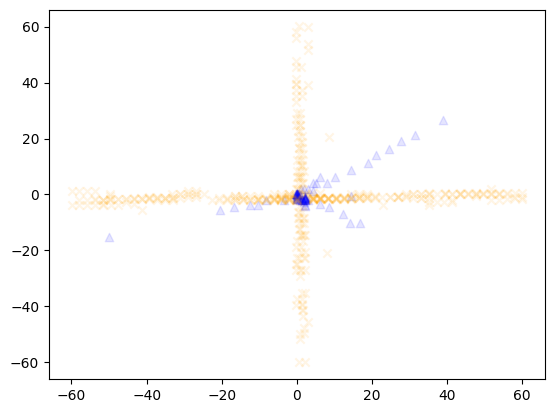

In [242]:
modules = [SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True)]
modules  += modules + modules + modules

fig, ax = plt.subplots()
for i, module in enumerate(modules):
    try:
        (reco_1x, reco_1y),   (ghosts_1x, ghosts_1y), _ = module.get_reco_and_ghost_hits(hits_x_centred[i], hits_y_centred[i])
        ax.scatter(reco_1x, reco_1y, color='blue', marker='^', label='Reco Hits Module 1', alpha=0.1)
        ax.scatter(ghosts_1x, ghosts_1y, color='orange', marker='x', label='Ghost Hits Module 1', alpha=0.1)
    except IndexError:
        continue

In [243]:
# modules = [SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
#            ]

# scatter = []

# rectangle_vertices = go.Mesh3d(
#     x=[30, -30, -30, 30, 30, -30, -30, 30,],
#     y=[30, 30, -30, -30, 30, 30, -30, -30,],
#     z=[500, 500, 500, 500, 500, 500, 500, 500],
#     color='rgba(244,22,100,0.6)'
# )

# import plotly.graph_objects as go
# from collections import defaultdict
# from tqdm import tqdm

# # Initialize dictionary to hold grouped data
# grouped_data = defaultdict(lambda: {"x": [], "y": [], "z": [], "marker": None})

# print(len(modules))

# # Loop through modules and group the data
# for i, module in enumerate(tqdm(modules)):
    
#     try:
#         (reco_x, reco_y), (ghosts_x, ghosts_y), _ = module.get_reco_and_ghost_hits(hits_x_centred[i], hits_y_centred[i])
#         # (sp_x, sp_y), _, _ = module.get_space_points(hits_x_centred[i], hits_y_centred[i])
#     except IndexError:
#         continue
    
#     # Group True Hits
#     grouped_data['True Hits']["x"].extend(hits_x_centred[i].tolist())
#     grouped_data['True Hits']["y"].extend(hits_y_centred[i].tolist())
#     grouped_data['True Hits']["z"].extend(hits_z[i].tolist())
#     grouped_data['True Hits']["marker"] = dict(size=1, color='green', opacity=1)
    
#     # Group Matched Hits
#     grouped_data['Matched Hits']["x"].extend(reco_x.tolist())
#     grouped_data['Matched Hits']["y"].extend(reco_y.tolist())
#     grouped_data['Matched Hits']["z"].extend(hits_z[i].tolist())
#     grouped_data['Matched Hits']["marker"] = dict(size=1, color='blue', opacity=1)
    
#     # Group Ghost Hits
#     grouped_data['Ghost Hits']["x"].extend(ghosts_x.tolist())
#     grouped_data['Ghost Hits']["y"].extend(ghosts_y.tolist())
#     grouped_data['Ghost Hits']["z"].extend(hits_z[i].tolist())
#     grouped_data['Ghost Hits']["marker"] = dict(size=1, color='red', opacity=1)

# # Create scatter traces for each group
# scatters = []
# for name, data in grouped_data.items():
#     scatters.append(go.Scatter3d(
#         x=data["x"], 
#         y=data["y"], 
#         z=data["z"], 
#         name=name,
#         mode='markers',
#         marker=data["marker"]
#     ))

# # Create the figure and add scatter traces
# fig = go.Figure(data=scatters)

# # Show the plot
# # fig.show()


# # # for i, module in enumerate(tqdm(modules)):

# # reco_x_all = np.array([])
# # reco_y_all = np.array([])

# # sp_x_all = np.array([])
# # sp_y_all = np.array([])

# # ghosts_x_all = np.array([])
# # ghosts_y_all = np.array([])

# # truth_x_all = np.array([])
# # truth_y_all = np.array([])
# # truth_z_all = np.array([])

# # for i, module in enumerate(tqdm(modules)):
    
# #     print(reco_x)
    
# #     try:
# #         (reco_x, reco_y), (ghosts_x, ghosts_y), _ = module.get_reco_and_ghost_hits(hits_x_centred[i], hits_y_centred[i])
# #         (sp_x, sp_y), _, _ = module.get_space_points(hits_x_centred[i], hits_y_centred[i])
# #     except IndexError:
# #         continue
    
# #     scatter.append(go.Scatter3d(x=hits_x_centred[i].tolist(), y=hits_y_centred[i].tolist(), z=hits_z[i].tolist(), name='True Hits', mode='markers',  marker=dict( size=1, color='green', opacity=1)))
# #     scatter.append(go.Scatter3d(x=reco_x, y=reco_y, z=hits_z[i].tolist(), mode='markers',  name='Matched Hits', marker=dict( size=1, color='blue', opacity=1)))
# #     scatter.append(go.Scatter3d(x=ghosts_x, y=ghosts_y, z=hits_z[i].tolist(), mode='markers',  name='Ghost Hits', marker=dict( size=1, color='red', opacity=1)))

    
# # #     reco_x_all = np.concatenate((reco_x, reco_x_all))
# # #     reco_y_all = np.concatenate((reco_y, reco_y_all))
    
# # #     sp_x_all = np.concatenate((sp_x, sp_x_all))
# # #     sp_y_all = np.concatenate((sp_y, sp_y_all))
    
# # #     ghosts_x_all = np.concatenate((ghosts_x, ghosts_x_all))
# # #     ghosts_y_all = np.concatenate((ghosts_y, ghosts_y_all))
    
# # #     truth_x_all = np.concatenate((hits_x_centred[i], truth_x_all))
# # #     truth_y_all = np.concatenate((hits_y_centred[i], truth_y_all))
# # #     truth_z_all = np.concatenate((hits_z[i], truth_z_all))
    

# # # scatter.append(go.Scatter3d(x=truth_x_all, y=truth_y_all, z=truth_z_all, name='True Hits', mode='markers',  marker=dict( size=1, color='green', opacity=0.5)))
# # # scatter.append(go.Scatter3d(x=reco_x_all, y=reco_y_all, z=truth_z_all, mode='markers',  name='Matched Hits', marker=dict( size=1, color='blue', opacity=1)))
# # # scatter.append(go.Scatter3d(x=ghosts_x_all, y=ghosts_y_all, z=truth_z_all, mode='markers',  name='Ghost Hits', marker=dict( size=1, color='red', opacity=1)))
# # # scatter.append(go.Scatter3d(x=sp_x_all, y=sp_y_all, z=truth_z_all, mode='markers',  name='Matched Hits', marker=dict( size=1, color='purple', opacity=1)))
  
    
# #     # print(f"{i}: x={hits_x_centred[i]}, y ={hits_y_centred[i]} ---- reco x={reco_y}, reco y={reco_y}")
    
# # # scatter.append(go.Scatter3d(x=hits_x_centred[i].tolist(), y=hits_y_centred[i].tolist(), z=hits_z[i].tolist(), name='True Hits', mode='markers',  marker=dict( size=1, color='green', opacity=0.5)))
# # # scatter.append(go.Scatter3d(x=reco_x, y=reco_y, z=hits_z[i].tolist(), mode='markers',  name='Matched Hits', marker=dict( size=1, color='blue', opacity=1)))
# # # scatter.append(go.Scatter3d(x=ghosts_x, y=ghosts_y, z=hits_z[i].tolist(), mode='markers',  name='Ghost Hits', marker=dict( size=1, color='red', opacity=1)))

# #     # print(f"{i=}")
    
# # fig = go.Figure(data=scatter)
# # Customize the layout
# fig.update_layout(
#     title="",
#     scene=dict(
#         xaxis_title='X Axis',
#         yaxis_title='Y Axis',
#         zaxis_title='Z Axis'
#     ),
#     width=1200, # Set the width here 
#     height=800, # Set the height here
#     # xaxis=dict(range=(-64/2, 64/2)), # Change the x-axis range 
#     # yaxis=dict(range=(-64/2, 64/2)),
# )

# fig.update_layout(
#     updatemenus=[
#         dict(
#             type='buttons',
#             buttons=[
#                 dict(
#                     label='Show True Hits',
#                     method='update',
#                     args=[{'visible': [True, False, False]}]
#                 ),
#                 dict(
#                     label='Show Matched Hits',
#                     method='update',
#                     args=[{'visible': [False, True, False]}]
#                 ),
#                 dict(
#                     label='Show Matched and Ghosts',
#                     method='update',
#                     args=[{'visible': [False, True, True]}]
#                 ),
#                 dict(
#                     label='Show Matched and True',
#                     method='update',
#                     args=[{'visible': [True, True, False]}]
#                 ),
#                 dict(
#                     label='Show All',
#                     method='update',
#                     args=[{'visible': [True, True, True]}]
#                 )
#             ]
#         )
#     ]
# )

# fig.show()
    

In [255]:
modules = [SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           ]

scatter = []

rectangle_vertices = go.Mesh3d(
    x=[30, -30, -30, 30, 30, -30, -30, 30,],
    y=[30, 30, -30, -30, 30, 30, -30, -30,],
    z=[500, 500, 500, 500, 500, 500, 500, 500],
    color='rgba(244,22,100,0.6)'
)

import plotly.graph_objects as go
from collections import defaultdict
from tqdm import tqdm

# Initialize dictionary to hold grouped data
grouped_data = defaultdict(lambda: {"x": [], "y": [], "z": [], "marker": None})

# print(len(modules))

# Loop through modules and group the data
# for i, module in enumerate(tqdm(modules)):
    
#     try:
#         (reco_x, reco_y), (ghosts_x, ghosts_y), _ = module.get_reco_and_ghost_hits(hits_x_centred[i], hits_y_centred[i])
#         # (sp_x, sp_y), _, _ = module.get_space_points(hits_x_centred[i], hits_y_centred[i])
#     except IndexError:
#         continue
    
    # Group True Hits
    # grouped_data['True Hits']["x"].extend(hits_x_centred[i].tolist())
    # grouped_data['True Hits']["y"].extend(hits_y_centred[i].tolist())
    # grouped_data['True Hits']["z"].extend(hits_z[i].tolist())
    # grouped_data['True Hits']["marker"] = dict(size=1, color='green', opacity=1)
    
    # # Group Matched Hits
    # grouped_data['Matched Hits']["x"].extend(reco_x.tolist())
    # grouped_data['Matched Hits']["y"].extend(reco_y.tolist())
    # grouped_data['Matched Hits']["z"].extend(hits_z[i].tolist())
    # grouped_data['Matched Hits']["marker"] = dict(size=1, color='blue', opacity=1)
    
    # # Group Ghost Hits
    # grouped_data['Ghost Hits']["x"].extend(ghosts_x.tolist())
    # grouped_data['Ghost Hits']["y"].extend(ghosts_y.tolist())
    # grouped_data['Ghost Hits']["z"].extend(hits_z[i].tolist())
    # grouped_data['Ghost Hits']["marker"] = dict(size=1, color='red', opacity=1)

# Create scatter traces for each group
# scatters = []
# for name, data in grouped_data.items():
#     scatters.append(go.Scatter3d(
#         x=data["x"], 
#         y=data["y"], 
#         z=data["z"], 
#         name=name,
#         mode='markers',
#         marker=data["marker"]
#     ))

# Create the figure and add scatter traces
# fig = go.Figure(data=scatters)

# Show the plot
# fig.show()


# # for i, module in enumerate(tqdm(modules)):

# reco_x_all = np.array([])
# reco_y_all = np.array([])

# sp_x_all = np.array([])
# sp_y_all = np.array([])

ghosts_x_all = np.array([])
ghosts_y_all = np.array([])

# truth_x_all = np.array([])
# truth_y_all = np.array([])
# truth_z_all = np.array([])



for i, module in enumerate(tqdm(modules)):
    
    # print(reco_x)
    
    try:
        (reco_x, reco_y), (ghosts_x, ghosts_y), _ = module.get_reco_and_ghost_hits(hits_x_centred[i], hits_y_centred[i])
        # (sp_x, sp_y), _, _ = module.get_space_points(hits_x_centred[i], hits_y_centred[i])
    except IndexError:
        continue
    
    scatter.append(go.Scatter3d(x=hits_x_centred[i].tolist(), y=hits_y_centred[i].tolist(), z=hits_z[i].tolist(), name='True Hits', mode='markers',  marker=dict( size=1, color='green', opacity=1)))
    scatter.append(go.Scatter3d(x=reco_x, y=reco_y, z=hits_z[i].tolist(), mode='markers',  name='Matched Hits', marker=dict( size=1, color='blue', opacity=1)))
    scatter.append(go.Scatter3d(x=ghosts_x, y=ghosts_y, z=hits_z[i].tolist(), mode='markers',  name='Ghost Hits', marker=dict( size=1, color='red', opacity=1)))

    
# #     reco_x_all = np.concatenate((reco_x, reco_x_all))
# #     reco_y_all = np.concatenate((reco_y, reco_y_all))
    
# #     sp_x_all = np.concatenate((sp_x, sp_x_all))
# #     sp_y_all = np.concatenate((sp_y, sp_y_all))
    
# #     ghosts_x_all = np.concatenate((ghosts_x, ghosts_x_all))
# #     ghosts_y_all = np.concatenate((ghosts_y, ghosts_y_all))
    
# #     truth_x_all = np.concatenate((hits_x_centred[i], truth_x_all))
# #     truth_y_all = np.concatenate((hits_y_centred[i], truth_y_all))
# #     truth_z_all = np.concatenate((hits_z[i], truth_z_all))
    

# # scatter.append(go.Scatter3d(x=truth_x_all, y=truth_y_all, z=truth_z_all, name='True Hits', mode='markers',  marker=dict( size=1, color='green', opacity=0.5)))
# # scatter.append(go.Scatter3d(x=reco_x_all, y=reco_y_all, z=truth_z_all, mode='markers',  name='Matched Hits', marker=dict( size=1, color='blue', opacity=1)))
# # scatter.append(go.Scatter3d(x=ghosts_x_all, y=ghosts_y_all, z=truth_z_all, mode='markers',  name='Ghost Hits', marker=dict( size=1, color='red', opacity=1)))
# # scatter.append(go.Scatter3d(x=sp_x_all, y=sp_y_all, z=truth_z_all, mode='markers',  name='Matched Hits', marker=dict( size=1, color='purple', opacity=1)))
  
    
#     # print(f"{i}: x={hits_x_centred[i]}, y ={hits_y_centred[i]} ---- reco x={reco_y}, reco y={reco_y}")
    
# # scatter.append(go.Scatter3d(x=hits_x_centred[i].tolist(), y=hits_y_centred[i].tolist(), z=hits_z[i].tolist(), name='True Hits', mode='markers',  marker=dict( size=1, color='green', opacity=0.5)))
# # scatter.append(go.Scatter3d(x=reco_x, y=reco_y, z=hits_z[i].tolist(), mode='markers',  name='Matched Hits', marker=dict( size=1, color='blue', opacity=1)))
# # scatter.append(go.Scatter3d(x=ghosts_x, y=ghosts_y, z=hits_z[i].tolist(), mode='markers',  name='Ghost Hits', marker=dict( size=1, color='red', opacity=1)))

#     # print(f"{i=}")
    
fig = go.Figure(data=scatter)
# Customize the layout
fig.update_layout(
    title="",
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    width=1200, # Set the width here 
    height=800, # Set the height here
    xaxis=dict(range=(-64/2, 64/2)), # Change the x-axis range 
    yaxis=dict(range=(-64/2, 64/2)),
)

fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            buttons=[
                dict(
                    label='Show True Hits',
                    method='update',
                    args=[{'visible': [True, False, False]}]
                ),
                dict(
                    label='Show Matched Hits',
                    method='update',
                    args=[{'visible': [False, True, False]}]
                ),
                dict(
                    label='Show Ghost Hits',
                    method='update',
                    args=[{'visible': [False, False, True]}]
                ),
                dict(
                    label='Show Matched and Ghosts',
                    method='update',
                    args=[{'visible': [False, True, True]}]
                ),
                dict(
                    label='Show Matched and True',
                    method='update',
                    args=[{'visible': [True, True, False]}]
                ),
                dict(
                    label='Show Ghost and True',
                    method='update',
                    args=[{'visible': [True, False, True]}]
                ),
                dict(
                    label='Show All',
                    method='update',
                    args=[{'visible': [True, True, True]}]
                )
            ]
        )
    ]
)

fig.show()
    

100%|██████████| 144/144 [00:26<00:00,  5.38it/s]


In [ ]:
reco_x_all = ak.Array([])
reco_y_all = ak.Array([])
ghosts_x_all = ak.Array([])
ghosts_y_all = ak.Array([])

hits_all_x = ak.Array([])
hits_all_y = ak.Array([])
hits_all_z = ak.Array([])
hits_all_q = ak.Array([])
hits_all_e = ak.Array([])
hits_all_l = ak.Array([])

for i, module in enumerate(tqdm(modules)):
    
    # print(reco_x)
    
    try:
        (reco_x, reco_y), (ghosts_x, ghosts_y), _ = module.get_reco_and_ghost_hits(hits_x_centred[i], hits_y_centred[i])
        
        hits_all_x = ak.concatenate([hits_all_x, reco_x, ghosts_x])
        hits_all_y = ak.concatenate([hits_all_y, reco_y, ghosts_y])
        hits_all_z = ak.concatenate([hits_all_z, reco_z ghosts_y])
    except IndexError:
        continue


fig = go.Figure(data=go.Scatter3d(x=hits_all_x.tolist(), y=hits_all_y.tolist(), z=hits_z.tolist(), name='True Hits', mode='markers',  marker=dict( size=1, color='green', opacity=1)))
# Customize the layout
fig.update_layout(
    title="",
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    width=1200, # Set the width here 
    height=800, # Set the height here
    xaxis=dict(range=(-64/2, 64/2)), # Change the x-axis range 
    yaxis=dict(range=(-64/2, 64/2)),
)



In [262]:
print(data.keys())

dict_keys(['x', 'y', 'z', 'marker'])


In [264]:
def export_event_to_root(event, outfile):
    
    new_file = uproot.recreate(outfile)
    
    new_file["Hits"] = {'fEvent': event['fEvent'], 
                        'vertex_x': event['vertex_x'], 
                        'vertex_y': event['vertex_y'], 
                        'vertex_z': event['vertex_z'], 
                        'nu_E': event['nu_E'], 
                        'nu_px': event['nu_px'], 
                        'nu_py': event['nu_py'],
                        'nu_pz': event['nu_pz'],
                        'nu_pdgc': event['nu_pdgc'],
                        'target_pdgc': event['target_pdgc'],
                        'isCC': event['isCC'], 
                        'cclepton_pdgc': event['cclepton_pdgc'], 
                        'cclepton_E': event['cclepton_E'], 
                        'cclepton_px': event['cclepton_px'], 
                        'cclepton_py': event['cclepton_py'],
                        'cclepton_pz': event['cclepton_pz'],
                        'x': event['x'],
                        'y': event['y'],
                        'z': event['z'], 
                        'E': event['E'],
                        'pdgc': event['pdgc'],
                        'charge': event['charge'], 
                        'layer': event['layer']
                        }

    

export_event_to_root(cc_tau_data, "Test_Event.root")

In [244]:
# for i, module in enumerate(tqdm(modules)):
    
    
#     try:
#         fig, ax = plt.subplots()
#         module.draw_hits(ax, hits_x_centred[i], hits_y_centred[i])
#         plt.show()
#     except IndexError:
#         continue

In [152]:
def _get_name_from_pdgc(pdgc):
    try:
        particle = Particle.from_pdgid(pdgc)
        
        particle_name = particle.name
        
        if pdgc < 0 and "+" not in particle_name and "-" not in particle_name:
            particle_name = f"anti-{particle_name}"
        
        return particle_name
        
    except InvalidParticle:
        return f"Unknown PDG Code: {pdgc}"
    except ParticleNotFound:
        return f"Particle not found: {pdgc}"
    
    
def _get_charge_from_pdgc(pdgc):
    try:
        particle = Particle.from_pdgid(pdgc)
        
        particle_charge = particle.charge
        
        return particle_charge
        
    except InvalidParticle:
        return f"Unknown PDG Code: {pdgc}"
    except ParticleNotFound:
        return f"Particle not found: {pdgc}"


def get_name_from_pdgc(pdgc):
    result = []
    try:
        len(pdgc)
        for p in pdgc:
            result.append(_get_name_from_pdgc(p))
    except TypeError:
        return _get_name_from_pdgc(pdgc)

    return np.array(result)


def get_charge_from_pdgc(pdgc):
    result = []
    try:
        len(pdgc)
        for p in pdgc:
            result.append(_get_charge_from_pdgc(p))
    except TypeError:
        return _get_name_from_pdgc(pdgc)
    
    return np.array(result)

neutrino_pdgc_to_label_dict = {12: r"$\nu_e$",
                               -12: r"$\bar{\nu}_e$",
                               14: r"$\nu_\mu$",
                               -14: r"$\bar{\nu}_\mu$",
                               16: r"$\nu_\tau$",
                               -16: r"$\bar{\nu}_\tau$",
                                }


def scatter_on_ax(ax, event_data, x_var, y_var, label, color,  alpha=1, marker_size=1):
    
    if len(event_data[x_var]) == 0:
        return None
    
    return ax.scatter(event_data[x_var], event_data[y_var], color=color, marker=",", label=label, alpha=alpha, s=marker_size)


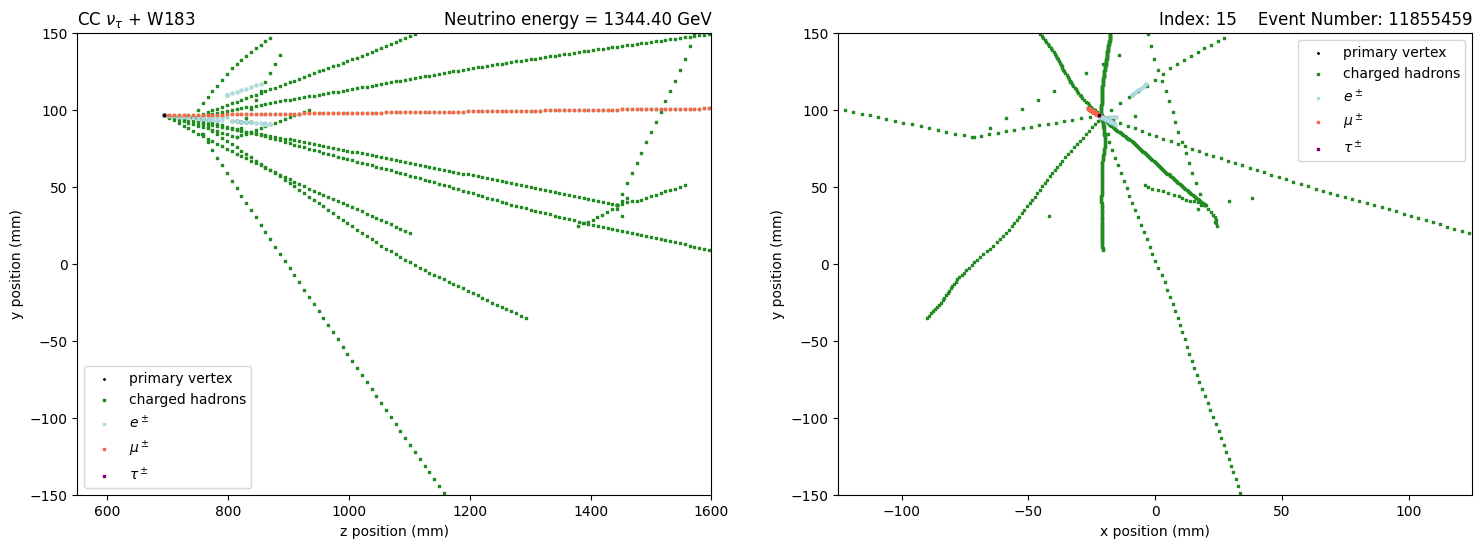

In [245]:

# for i, event in enumerate(tau_nu_data_sorted):

neutrino_pdgc = event['nu_pdgc']
neutrino_energy = event['nu_E']
target_pdgc = event['target_pdgc']
event_number = event['fEvent']
vx = event['vertex_x']
vy = event['vertex_y']
vz = event['vertex_z']
is_cc = bool(event['isCC'])
is_cc_label = "CC" if is_cc else "NC"

fig, ax = plt.subplots(ncols=2,figsize=(18, 6))

ax[0].scatter(vz, vy, color="black", marker='x', s=1.5, label="primary vertex", zorder=100)
ax[1].scatter(vx, vy, color="black", marker='x', s=1.5, label="primary vertex", zorder=100)

marker_size = 1
alpha = 1

kinematics = ak.zip({'x': event['x'], "y": event['y'], "z": event['z'], 'pdgc': event['pdgc']})

electrons = kinematics[np.where(np.abs(kinematics['pdgc']) == 11)]
muons = kinematics[np.where(np.abs(kinematics['pdgc']) == 13)]
taus = kinematics[np.where(np.abs(kinematics['pdgc']) == 15)]

gluons = kinematics[np.where(np.abs(kinematics['pdgc']) == 21)]
photons = kinematics[np.where(np.abs(kinematics['pdgc']) == 22)]
charged_hadrons = kinematics[np.where(np.abs(kinematics['pdgc']) > 37)]
neutral_hadrons = kinematics[np.where(np.abs(kinematics['pdgc']) > 37)]
charged_hadrons = kinematics[np.where(get_charge_from_pdgc(kinematics['pdgc']) != 0)]
neutral_hadrons = kinematics[np.where(get_charge_from_pdgc(kinematics['pdgc']) == 0)]

# scatter_on_ax(ax[0], neutral_hadrons, "z", "y", "neutral hadrons", 'grey', alpha=0.5, marker_size=marker_size)
scatter_on_ax(ax[0], charged_hadrons, "z", "y", "charged hadrons", 'forestgreen', alpha=alpha, marker_size=marker_size)
# scatter_on_ax(ax[0], photons, "z", "y", r"$\gamma$", 'yellow', alpha=0.5, marker_size=marker_size)
# scatter_on_ax(ax[0], gluons, "z", "y", r"$g$", 'orange', alpha=0.5, marker_size=marker_size)
scatter_on_ax(ax[0], electrons, "z", "y", r"$e^\pm$", 'lightblue', alpha=alpha, marker_size=marker_size)
scatter_on_ax(ax[0], muons, "z", "y", r"$\mu^\pm$", 'tomato', alpha=alpha, marker_size=marker_size)
scatter_on_ax(ax[0], taus, "z", "y", r"$\tau^\pm$", 'purple', alpha=alpha, marker_size=marker_size)

# scatter_on_ax(ax[0], neutral_hadrons, "x", "y", "neutral hadrons", 'grey', alpha=0.5, marker_size=marker_size)
scatter_on_ax(ax[1], charged_hadrons, "x", "y", "charged hadrons", 'forestgreen', alpha=alpha, marker_size=marker_size)
# scatter_on_ax(ax[0], photons, "x", "y", r"$\gamma$", 'yellow', alpha=0.5, marker_size=marker_size)
# scatter_on_ax(ax[0], gluons, "x", "y", r"$g$", 'orange', alpha=0.5, marker_size=marker_size)
scatter_on_ax(ax[1], electrons, "x", "y", r"$e^\pm$", 'lightblue', alpha=alpha, marker_size=marker_size)
scatter_on_ax(ax[1], muons, "x", "y", r"$\mu^\pm$", 'tomato', alpha=alpha, marker_size=marker_size)
scatter_on_ax(ax[1], taus, "x", "y", r"$\tau^\pm$", 'purple', alpha=alpha, marker_size=marker_size)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

ax[0].set_title(f"{is_cc_label} {neutrino_pdgc_to_label_dict[neutrino_pdgc]} + {get_name_from_pdgc(target_pdgc)}", loc="left")
ax[0].set_title(f"Neutrino energy = {neutrino_energy:.2f} GeV", loc="right")
ax[1].set_title(f"Index: {i}    Event Number: {event_number}", loc="right")

ax[0].legend(by_label.values(), by_label.keys())# , ncols=2) #, loc='center right', bbox_to_anchor=(1.55, 0.75))
ax[1].legend(by_label.values(), by_label.keys())# , ncols=2) #, loc='center right', bbox_to_anchor=(1.55, 0.75)) 

ax[0].set_xlabel("z position (mm)")
ax[0].set_ylabel("y position (mm)")
ax[0].set_xlim((550, 1600))
ax[0].set_ylim((-150, 150))

ax[1].set_xlabel("x position (mm)")
ax[1].set_ylabel("y position (mm)")
ax[1].set_xlim((-125, 125))
ax[1].set_ylim((-150, 150))

# plt.savefig(f"{output_dir}/event_{i}_particle-dist-x-y-z-y.png", dpi=300, bbox_inches='tight')
plt.show()
# plt.close()

In [254]:
modules = [SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           ]

scatter = []
for i, module in enumerate(tqdm(modules)):
    (reco_x, reco_y), (ghosts_x, ghosts_y), _ = module.get_reco_and_ghost_hits(hits_x_centred[i], hits_y_centred[i])
    
    # print(i, hits_x_centred[i], hits_y_centred[i], reco_x, hits_z[i])
    
    scatter.append(go.Scatter3d(x=hits_x_centred[i].tolist(), y=hits_y_centred[i].tolist(), z=hits_z[i].tolist(), mode='markers',  marker=dict( size=1, color='green', opacity=0.5)))
    scatter.append(go.Scatter3d(x=reco_x.tolist(), y=reco_y.tolist(), z=hits_z[i].tolist(), mode='markers',  marker=dict( size=1, color='blue', opacity=1)))
    scatter.append(go.Scatter3d(x=ghosts_x.tolist(), y=ghosts_y.tolist(), z=hits_z[i].tolist(), mode='markers',  marker=dict( size=1, color='red', opacity=1)))
    # scatter.append(go.Scatter3d(x=[0], y=[0], z=hits_z[i].tolist(), mode='markers',  marker=dict( size=5, color='black', opacity=1)))

fig = go.Figure(data=scatter)
# Customize the layout
fig.update_layout(
    title="",
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    width=1200, # Set the width here 
    height=800, # Set the height here
    # xaxis=dict(range=(-64/2, 64/2)), # Change the x-axis range 
    # yaxis=dict(range=(-64/2, 64/2)),
)

fig.show()
    

100%|██████████| 104/104 [00:14<00:00,  7.04it/s]


In [249]:
modules = []

vertical_module_pos = [(63.56*0.5, 128.05*0.5),
                       (63.56*1.5, 128.05*0.5),
                       (-63.56*0.5, 128.05*0.5),
                       (-63.56*1.5, 128.05*0.5),
                       (-63.56*0.5, -128.05*0.5),
                       (-63.56*1.5, -128.05*0.5),
                       (63.56*0.5, -128.05*0.5),
                       (63.56*1.5, -128.05*0.5),
                      ]

horizontal_module_pos = [(128.05*0.5,  63.56*0.5),
                         (128.05*0.5,  63.56*1.5),
                         (128.05*0.5,  -63.56*0.5),
                         (128.05*0.5,  -63.56*1.5),
                         (-128.05*0.5,  -63.56*0.5),
                         (-128.05*0.5,  -63.56*1.5),
                         (-128.05*0.5,  63.56*0.5),
                         (-128.05*0.5,  63.56*1.5),
                        ]


for i in range(0, 132):
    rotation = 0
    flip = False
    
    modules_in_layer = []
    
    mod_pos = vertical_module_pos
    if i % 2 != 0:
        mod_pos = horizontal_module_pos
        rotation = np.pi/2
    
    for (xpos, ypos) in mod_pos:
        
        if i % 3 == 0 or i % 4 == 0:
            flip = True
        
        modules_in_layer.append(SCTModule(xpos=xpos, ypos=ypos, rotation=rotation, flip=flip))
    
    modules.append(modules_in_layer)
    # break

In [253]:
scatter = []
for i, modules_in_layer in enumerate(tqdm(modules)):
    for j, module in enumerate(modules_in_layer):
        # print(f"Layer {i} - Module {j} - x={module.xpos} y={module.ypos}")
        # print(f"Hits: {hits_x[i], hits_y[i]}")
        try:
            (reco_x, reco_y), (ghosts_x, ghosts_y), _ = module.get_reco_and_ghost_hits(hits_x[i], hits_y[i])
        # print(f"Reco: {(reco_x, reco_y)}")
        # print(f"Ghosts: {(ghosts_x, ghosts_y)}")
        except IndexError as e:
            continue
        #     print(e)
        #     break
        
        # print(i, hits_x_centred[i], hits_y_centred[i], reco_x, hits_z[i])
        c = 'black'
        if j % 2 == 0:
            c = "grey"
            
        # scatter.append(go.Scatter3d(x=[module.xpos+module.width/2, module.xpos+module.width/2, module.xpos-module.width/2], y=[module.ypos], z=hits_z[i].tolist(), mode='markers',  marker=dict( size=5, color=c, opacity=1)))
        
        scatter.append(go.Scatter3d(x=hits_x[i].tolist(), y=hits_y[i].tolist(), z=hits_z[i].tolist(), mode='markers', name="True Hits", marker=dict( size=1, color='green', opacity=1)))
        scatter.append(go.Scatter3d(x=reco_x.tolist(), y=reco_y.tolist(), z=hits_z[i].tolist(), mode='markers', name='Matched Hits', marker=dict( size=1, color='blue', opacity=1)))
        scatter.append(go.Scatter3d(x=ghosts_x.tolist(), y=ghosts_y.tolist(), z=hits_z[i].tolist(), mode='markers', name='Ghost Hits', marker=dict( size=1, color='red', opacity=1)))
    # break
        # scatter.append(go.Scatter3d(x=[0], y=[0], z=hits_z[i].tolist(), mode='markers',  marker=dict( size=5, color='black', opacity=1)))

fig = go.Figure(data=scatter)
# Customize the layout
fig.update_layout(
    title="",
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    width=1200, # Set the width here 
    height=800, # Set the height here
    # xaxis=dict(range=(-64/2, 64/2)), # Change the x-axis range 
    # yaxis=dict(range=(-64/2, 64/2)),
)

fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            buttons=[
                dict(
                    label='Show True Hits',
                    method='update',
                    args=[{'visible': [True, False, False]}]
                ),
                dict(
                    label='Show Matched Hits',
                    method='update',
                    args=[{'visible': [False, True, False]}]
                ),
                dict(
                    label='Show Matched and Ghosts',
                    method='update',
                    args=[{'visible': [False, True, True]}]
                ),
                dict(
                    label='Show Matched and True',
                    method='update',
                    args=[{'visible': [True, True, False]}]
                ),
                dict(
                    label='Show Ghost and True',
                    method='update',
                    args=[{'visible': [True, False, True]}]
                ),
                dict(
                    label='Show All',
                    method='update',
                    args=[{'visible': [True, True, True]}]
                )
            ]
        )
    ]
)
fig.show()
    

100%|██████████| 132/132 [00:32<00:00,  4.09it/s]
